In [1]:
import os
from glob import glob
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
#from netCDF4 import Dataset
from scipy.io import loadmat

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(28*3)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [9]:
client

Client Scheduler: tcp://10.148.1.2:56043 Dashboard: http://10.148.1.2:8787/status,Cluster Workers: 84 Cores: 168 Memory: 719.88 GB


___________
# 1. Read Zach's data, and store as .nc files every one hour (9415 .nc files) 

In [6]:
# the path where (Zach's) LLC4320 data are already stored
LLC_data_folder = '/home1/datawork/xyu/OSMOSIS_llc4320/'
# the path where the data will be re-stored
out_dir_nc = '/home1/scratch/xyu/OSMOSIS_llc4320/nc_file/'

# variable 
v = 'U'

In [7]:
# search for right files, for example: Theta_177x201x52.*
filenames = sorted(glob(LLC_data_folder+v+'/'+v+'_177x201x52.*')) 
print('Number of files processed: %d' %len(filenames))

# store in netcdf files
fsize_bound = 5*1e6

for i in np.arange(len(filenames)):

    #
    file_out = out_dir_nc+'/%s_t%05d.nc'%(v, i)
          
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        
        ds = np.fromfile(filenames[i] , dtype='>f').reshape(52,201,177)
        ds = np.array(ds)
        ds = xr.DataArray(ds, dims=['depth','lat','lon_g'])
        ds = np.real(ds).rename(v)
        ds = ds.load() # this may be required in order to prevent pickle related errors

        #
        while True:
            try:
                ds.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

            except:
                print('failure')
            break

    else:
        print('t=%d - allready processed'%(i))      

Number of files processed: 9415


# 2. Add coordinates and put variables into one xarray file

In [ ]:
filenames = sorted(glob(out_dir_nc+v+'_t*.nc')) 
print('Number of files processed: %d' %len(filenames))
%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
print(ds)

Number of files processed: 9415


In [10]:
Depth = loadmat(LLC_data_folder+'grid/dpt52.mat')['dpt52']
Depth = np.array(Depth)
Depth = xr.DataArray(Depth, dims=['none','depth'])
Depth = xr.DataArray.squeeze(Depth, dim='none')
Depth = np.real(Depth).rename('Depth')

In [11]:
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

In [12]:
ds = ds.assign_coords(depth=Depth) 
ds = ds.assign_coords(time=np.arange(len(filenames))*3600/86400) 
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon_g: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: lat, lon_g
Data variables:
    U        (time, depth, lat, lon_g) float32 dask.array<chunksize=(1, 52, 201, 177), meta=np.ndarray>


In [11]:
chunks = {'time': 9415, 'lat': 201, 'lon_g': 177, 'depth':1}
ds = ds.chunk(chunks)
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon_g: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: lat, lon_g
Data variables:
    U        (time, depth, lat, lon_g) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(9415, 1, 201, 177)>


In [12]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

file_out = out_dir_zarr+'/%s_total_rechunk.zarr'%(v)
%time ds.to_zarr(file_out, mode='w')     

CPU times: user 50.4 s, sys: 2.85 s, total: 53.3 s
Wall time: 1min 44s


# Read rechunked data

In [15]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

ds = xr.open_zarr(out_dir_zarr+v+'_total_rechunk.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon_g: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: lat, lon_g
Data variables:
    U        (time, depth, lat, lon_g) float32 dask.array<chunksize=(1883, 1, 20, 17), meta=np.ndarray>

 data size: 69.7 GB


CPU times: user 324 ms, sys: 16 ms, total: 340 ms
Wall time: 443 ms


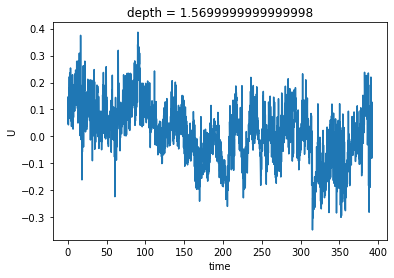

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


In [16]:
%time ds[v].isel(depth=1, lat=slice(50,100), lon_g=slice(50,100)).mean(dim=['lat','lon_g']).plot()

In [19]:
# the path where the data will be re-stored
LLC_data_folder_data_store = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'
filename_grid = sorted(glob(LLC_data_folder_data_store+'Grid.nc')) 

grid = xr.open_mfdataset(filename_grid)
grid

<xarray.Dataset>
Dimensions:  (lat: 201, lat_g: 201, lon: 177, lon_g: 177)
Coordinates:
    XC       (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    YC       (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    XG       (lat_g, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    YG       (lat_g, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    CS       (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    SN       (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    Depth    (lat, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dxC      (lat, lon_g) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyC      (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dxG      (lat_g, lon) float32 dask.array<shape=(201, 177), chunksize=(201, 177)>
    dyG      (lat, lon_g) float32 dask.array<shape=(201, 177), chunk

In [20]:
lat = grid.YC.isel(lon=1)
lon = grid.XC.isel(lat=1)

lat_g = grid.YG.isel(lon_g=1)
lon_g = grid.XG.isel(lat_g=1)

In [26]:
lat_g = grid.YG.isel(lon_g=1)
lat_g

<xarray.DataArray 'YG' (lat_g: 201)>
dask.array<shape=(201,), dtype=float32, chunksize=(201,)>
Coordinates:
    XG       (lat_g) float32 dask.array<shape=(201,), chunksize=(201,)>
    YG       (lat_g) float32 dask.array<shape=(201,), chunksize=(201,)>
  * lat_g    (lat_g) float32 47.39811 47.41132 47.424526 47.43773 47.45093 ...
    lon_g    float32 -18.020834

# the old one -- does not consider grid

In [24]:
ds = ds.assign_coords(depth=Depth) 
ds = ds.assign_coords(time=np.arange(len(filenames))*3600/86400) 
lat = LLC_YC.isel(lon=1)
lon = LLC_XC.isel(lat=1)
ds = ds.assign_coords(lat=lat) 
ds = ds.assign_coords(lon=lon)
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat      (lat) >f4 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) >f4 -18.03125 -18.010416 -17.989584 -17.96875 -17.947916 ...
Data variables:
    U        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>


In [25]:
ds = ds.assign_coords(dtime=xr.DataArray(iters_to_date(np.arange(len(filenames))), dims=['time']))
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat      (lat) >f4 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) >f4 -18.03125 -18.010416 -17.989584 -17.96875 -17.947916 ...
    dtime    (time) datetime64[ns] 2011-09-13 2011-09-13T01:00:00 ...
Data variables:
    U        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>


In [26]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'

file_out = out_dir_zarr+'/%s_total.zarr'%(v)
%time ds.to_zarr(file_out, mode='w')     

CPU times: user 29.9 s, sys: 1.74 s, total: 31.6 s
Wall time: 33 s


In [30]:
ds = xr.open_zarr(out_dir_zarr+v+'_total.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    dtime    (time) datetime64[ns] dask.array<shape=(9415,), chunksize=(9415,)>
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Data variables:
    U        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>

 data size: 69.7 GB


CPU times: user 1min 2s, sys: 4.34 s, total: 1min 6s
Wall time: 1min 37s


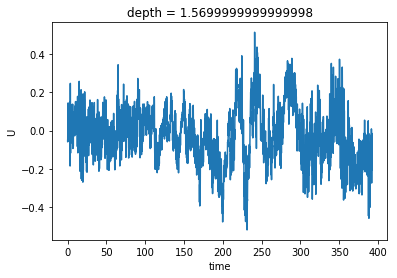

In [31]:
%time ds[v].isel(depth=1, lat=slice(90,100), lon=slice(90,100)).mean(dim=['lat','lon']).plot()

In [17]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1